In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go
from scipy.stats import norm

In [2]:
# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

In [3]:
# ================== Financial Parameters ==================
K = 3.         # Strike price
T = 1.0            # Time to maturity (1 year)
r = 0.05           # Risk-free rate
sigma = 0.2         # Volatility
S_max = 2 * K       # Maximum stock price for boundary
call_put = 'call'
kind = 'vanilla'
is_american = False  # Set False for European option

In [4]:
# ================== Black-Scholes PDE ==================
def bs_pde(pinn, S, tau, sigma, r):
    S = S.clone().requires_grad_(True)
    tau = tau.clone().requires_grad_(True)
    
    V = pinn(S, tau, sigma, r)
    V_tau = torch.autograd.grad(V.sum(), tau, create_graph=True)[0]
    V_S = torch.autograd.grad(V.sum(), S, create_graph=True)[0]
    V_SS = torch.autograd.grad(V_S.sum(), S, create_graph=True)[0]
    
    # Black-Scholes PDE: ∂V/∂τ = ½σ²S²∂²V/∂S² + rS∂V/∂S - rV
    residual = V_tau - (0.5 * sigma**2 * S**2 * V_SS + r * S * V_S - r * V)
    return residual

# ================== Greeks Computation ==================
def compute_greeks(pinn, S, tau, sigma, r):
    """
    Compute option Greeks using autodiff (no finite differences).
    
    Args:
        pinn: Trained PINN model
        S: Spot price tensor (shape: [batch_size, 1], requires_grad=True)
        tau: Time to maturity tensor (shape: [batch_size, 1], requires_grad=True)
        sigma: Volatility tensor (shape: [batch_size, 1], requires_grad=True)
        r: Interest rate tensor (shape: [batch_size, 1], requires_grad=True)
        
    Returns:
        Dictionary of Greeks (all values detached and converted to floats)
    """
    # Ensure all inputs require gradients
    S = S.clone().requires_grad_(True)
    tau = tau.clone().requires_grad_(True)
    sigma = sigma.clone().requires_grad_(True)
    r = r.clone().requires_grad_(True)
    
    # Forward pass
    V = pinn(S, tau, sigma, r)
    
    # --- Compute Greeks via autodiff ---
    # Delta (∂V/∂S)
    Delta = torch.autograd.grad(V.sum(), S, create_graph=True, retain_graph=True)[0]
    
    # Gamma (∂²V/∂S²)
    Gamma = torch.autograd.grad(Delta.sum(), S, retain_graph=True)[0]
    
    # Theta (∂V/∂τ)
    Theta = -torch.autograd.grad(V.sum(), tau, retain_graph=True)[0]
    
    # Vega (∂V/∂σ)
    Vega = torch.autograd.grad(V.sum(), sigma, retain_graph=True)[0]
    
    # Rho (∂V/∂r)
    Rho = torch.autograd.grad(V.sum(), r)[0]
    
    return {
        'Price': V.mean().item(),
        'Delta': Delta.mean().item(),
        'Gamma': Gamma.mean().item(),
        'Theta': Theta.mean().item(),
        'Vega': Vega.mean().item(),
        'Rho': Rho.mean().item()
    }

# ================== American Option Penalty ==================
def american_penalty(pinn, call_put, kind, S, tau, K, sigma, r):
    V_pred = pinn(S, tau, sigma, r)
    if kind == 'vanilla':
        if call_put == 'call':
            payoff = torch.relu(S - K)  # max(S-K, 0)
        elif call_put == 'put':
            payoff = torch.relu(K - S)  # max(K-S, 0)
        else:
            raise ValueError("Invalid call_put value")
    elif kind == 'digital':
        if call_put == 'call':
            payoff = torch.where(S >= K, 1, 0)
        elif call_put == 'put':
            payoff = torch.where(S <= K, 1, 0)
        else:
            raise ValueError("Invalid call_put value")
    return torch.mean(torch.relu(payoff - V_pred))  # Penalty if V < payoff

# ================== Setting up the Payoff ==================
def set_payoff(call_put, kind, S_max, T, N_points):
    terminal_S = torch.linspace(0, S_max, N_points).view(-1, 1)
    terminal_tau = torch.zeros(N_points, 1)
    boundary_S0 = torch.zeros(N_points, 1)
    boundary_Smax = S_max * torch.ones(N_points, 1)
    boundary_tau = torch.linspace(0, T, N_points).view(-1, 1)

    if kind == 'vanilla':
        if call_put == 'call':
            terminal_V = torch.relu(terminal_S - K)
            boundary_V0 = torch.zeros(N_points, 1)
            boundary_Vmax = boundary_Smax - K * torch.exp(-r * boundary_tau)
        elif call_put == 'put':
            terminal_V = torch.relu(K - terminal_S)
            boundary_V0 = K * torch.exp(-r * boundary_tau)
            boundary_Vmax = torch.zeros(N_points, 1)
    elif kind == 'digital':
        if call_put == 'call':
            terminal_V = torch.where(terminal_S >= K, 1, 0)
            boundary_V0 = torch.zeros(N_points, 1)
            boundary_Vmax = torch.ones(N_points, 1)
        elif call_put == 'put':
            terminal_V = torch.where(terminal_S <= K, 1, 0)
            boundary_V0 = torch.ones(N_points, 1)
            boundary_Vmax = torch.zeros(N_points, 1)

    return terminal_S, terminal_tau, terminal_V, boundary_S0, boundary_Smax, boundary_tau, boundary_V0, boundary_Vmax

In [5]:
# ================== PINN Architecture ==================
class PINN_digital(nn.Module):
    def __init__(self):
        super(PINN_digital, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(4, 20),   # Input: (S, tau, sigma, r)
            nn.Tanh(),
            nn.Linear(20, 20),
            nn.Tanh(),
            nn.Linear(20, 20),
            nn.Tanh(),
            nn.Linear(20, 1),   # Output: V(S, tau, sigma, r)
            nn.Sigmoid(),      # Ensures V ∈ [0, 1]
        )
        
    def forward(self, S, tau, sigma, r):
        # Broadcast sigma and r to match S shape
        sigma_tensor = torch.ones_like(S) * sigma
        r_tensor = torch.ones_like(S) * r
        inputs = torch.cat([S, tau, sigma_tensor, r_tensor], dim=1)
        return self.net(inputs)
    
class PINN_vanilla(nn.Module):
    def __init__(self):
        super(PINN_vanilla, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(4, 20),   # Input: (S, tau, sigma, r)
            nn.Tanh(),
            nn.Linear(20, 20),
            nn.Tanh(),
            nn.Linear(20, 20),
            nn.Tanh(),
            nn.Linear(20, 1),   # Output: V(S, tau, sigma, r)
            nn.Softplus(),      # Ensures V >= 0
        )
        
    def forward(self, S, tau, sigma, r):
        inputs = torch.cat([S, tau, sigma, r], dim=1)
        return self.net(inputs)


# ================== Training Setup ==================
if kind == 'vanilla':
    pinn = PINN_vanilla()
elif kind == 'digital':
    pinn = PINN_digital()
else:
    raise ValueError("Invalid kind value")

optimizer = torch.optim.Adam(pinn.parameters(), lr=0.001)

# Grid parameters
N_points = 100

In [6]:
# ================== Training Loop with EMA Tracking ==================
epochs = 20000
train_losses = []
ema_loss = None  # Initialize EMA loss
ema_alpha = 0.1  # Smoothing factor for EMA
best_loss = float('inf')
wait = 0
early_stop_threshold = 1e-8
if kind == 'vanilla':
    early_stopping_patience = 1000
else:
    early_stopping_patience = 1000

# Convert sigma and r to tensors (but they won't be trained)
sigma_tensor = torch.tensor(sigma, dtype=torch.float32).view(1, 1)
r_tensor = torch.tensor(r, dtype=torch.float32).view(1, 1)

terminal_S, terminal_tau, terminal_V, boundary_S0, boundary_Smax, boundary_tau, boundary_V0, boundary_Vmax = set_payoff(call_put, kind, S_max, T, N_points)

for epoch in range(epochs):
    optimizer.zero_grad()
    
    # Broadcast sigma and r to match batch sizes
    sigma_terminal = sigma_tensor.expand_as(terminal_S)
    r_terminal = r_tensor.expand_as(terminal_S)
    
    sigma_boundary = sigma_tensor.expand_as(boundary_S0)
    r_boundary = r_tensor.expand_as(boundary_S0)
    
    # --- Loss components ---
    # Terminal condition loss
    pred_terminal = pinn(terminal_S, terminal_tau, sigma_terminal, r_terminal)
    loss_terminal = torch.mean((pred_terminal - terminal_V)**2)
    
    # Boundary condition loss
    pred_boundary0 = pinn(boundary_S0, boundary_tau, sigma_boundary, r_boundary)
    pred_boundary_max = pinn(boundary_Smax, boundary_tau, sigma_boundary, r_boundary)
    loss_boundary = (torch.mean((pred_boundary0 - boundary_V0)**2) + 
                    torch.mean((pred_boundary_max - boundary_Vmax)**2))
    
    # PDE residual loss
    S_colloc = torch.rand(N_points, 1, requires_grad=True) * S_max
    tau_colloc = torch.rand(N_points, 1, requires_grad=True) * T
    sigma_colloc = sigma_tensor.expand_as(S_colloc)
    r_colloc = r_tensor.expand_as(S_colloc)
    residual = bs_pde(pinn, S_colloc, tau_colloc, sigma_colloc, r_colloc)
    loss_pde = torch.mean(residual**2)
    
    # American option penalty (if enabled)
    loss_american = american_penalty(pinn, call_put, kind, S_colloc, tau_colloc, K, sigma_colloc, r_colloc) if is_american else torch.tensor(0.0)
    
    # Total loss
    loss = loss_terminal + loss_boundary + loss_pde + 0.5 * loss_american
    train_losses.append(loss.item())
    loss.backward()
    optimizer.step()
    
    # --- EMA loss calculation ---
    ema_loss = ema_alpha * loss.item() + (1 - ema_alpha) * ema_loss if ema_loss is not None else loss.item()
    
    # --- Early stopping ---
    if epoch > 100:  # Wait for EMA to stabilize
        if loss.item() < best_loss - early_stop_threshold:
            best_loss = loss.item()
            wait = 0
        else:
            wait += 1
            if wait >= early_stopping_patience:
                print(f"\nEarly stopping triggered at epoch {epoch}")
                print(f"Final Loss: {loss.item():.6f} | Best EMA: {ema_loss:.6f}")
                break
    
    # --- Progress logging ---
    if epoch % 500 == 0 or epoch == epochs - 1:
        print(f"Epoch {epoch:4d} | Loss: {loss.item():.6f} | EMA: {ema_loss:.6f} | "
              f"Terminal: {loss_terminal.item():.6f} | "
              f"Boundary: {loss_boundary.item():.6f} | "
              f"PDE: {loss_pde.item():.6f}" + 
              (f" | American: {loss_american.item():.6f}" if is_american else ""))

# Final training summary
print("\n=== Training Complete ===")
print(f"Best Loss: {best_loss:.6f}")
print(f"Final EMA: {ema_loss:.6f}")

# ================== Solution Prediction ==================
S_test = torch.linspace(0, S_max, N_points).view(-1, 1)
tau_test = torch.linspace(0, T, N_points).view(-1, 1)
S_grid, Tau_grid = torch.meshgrid(S_test.squeeze(), tau_test.squeeze())

with torch.no_grad():
    # Flatten grids and compute V
    S_flat = S_grid.reshape(-1, 1)
    Tau_flat = Tau_grid.reshape(-1, 1)
    sigma_pred = sigma_tensor.expand_as(S_flat)
    r_pred = r_tensor.expand_as(S_flat)
    V_pred = pinn(S_flat, Tau_flat, sigma_pred, r_pred)
    V_pred = V_pred.reshape(N_points, N_points).numpy()

Epoch    0 | Loss: 7.439759 | EMA: 7.439759 | Terminal: 0.974728 | Boundary: 6.464365 | PDE: 0.000665
Epoch  500 | Loss: 0.017635 | EMA: 0.018167 | Terminal: 0.007253 | Boundary: 0.004028 | PDE: 0.006354
Epoch 1000 | Loss: 0.014095 | EMA: 0.012914 | Terminal: 0.006487 | Boundary: 0.002844 | PDE: 0.004763
Epoch 1500 | Loss: 0.010242 | EMA: 0.009424 | Terminal: 0.005332 | Boundary: 0.001663 | PDE: 0.003247
Epoch 2000 | Loss: 0.006130 | EMA: 0.005896 | Terminal: 0.003984 | Boundary: 0.000880 | PDE: 0.001265
Epoch 2500 | Loss: 0.003252 | EMA: 0.003227 | Terminal: 0.002533 | Boundary: 0.000226 | PDE: 0.000493
Epoch 3000 | Loss: 0.001990 | EMA: 0.001906 | Terminal: 0.001560 | Boundary: 0.000028 | PDE: 0.000403
Epoch 3500 | Loss: 0.001433 | EMA: 0.001440 | Terminal: 0.001122 | Boundary: 0.000025 | PDE: 0.000286
Epoch 4000 | Loss: 0.001185 | EMA: 0.001214 | Terminal: 0.000922 | Boundary: 0.000038 | PDE: 0.000225
Epoch 4500 | Loss: 0.001055 | EMA: 0.001033 | Terminal: 0.000797 | Boundary: 0.000

c:\Users\svbor\anaconda3\Lib\site-packages\torch\functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\TensorShape.cpp:3638.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


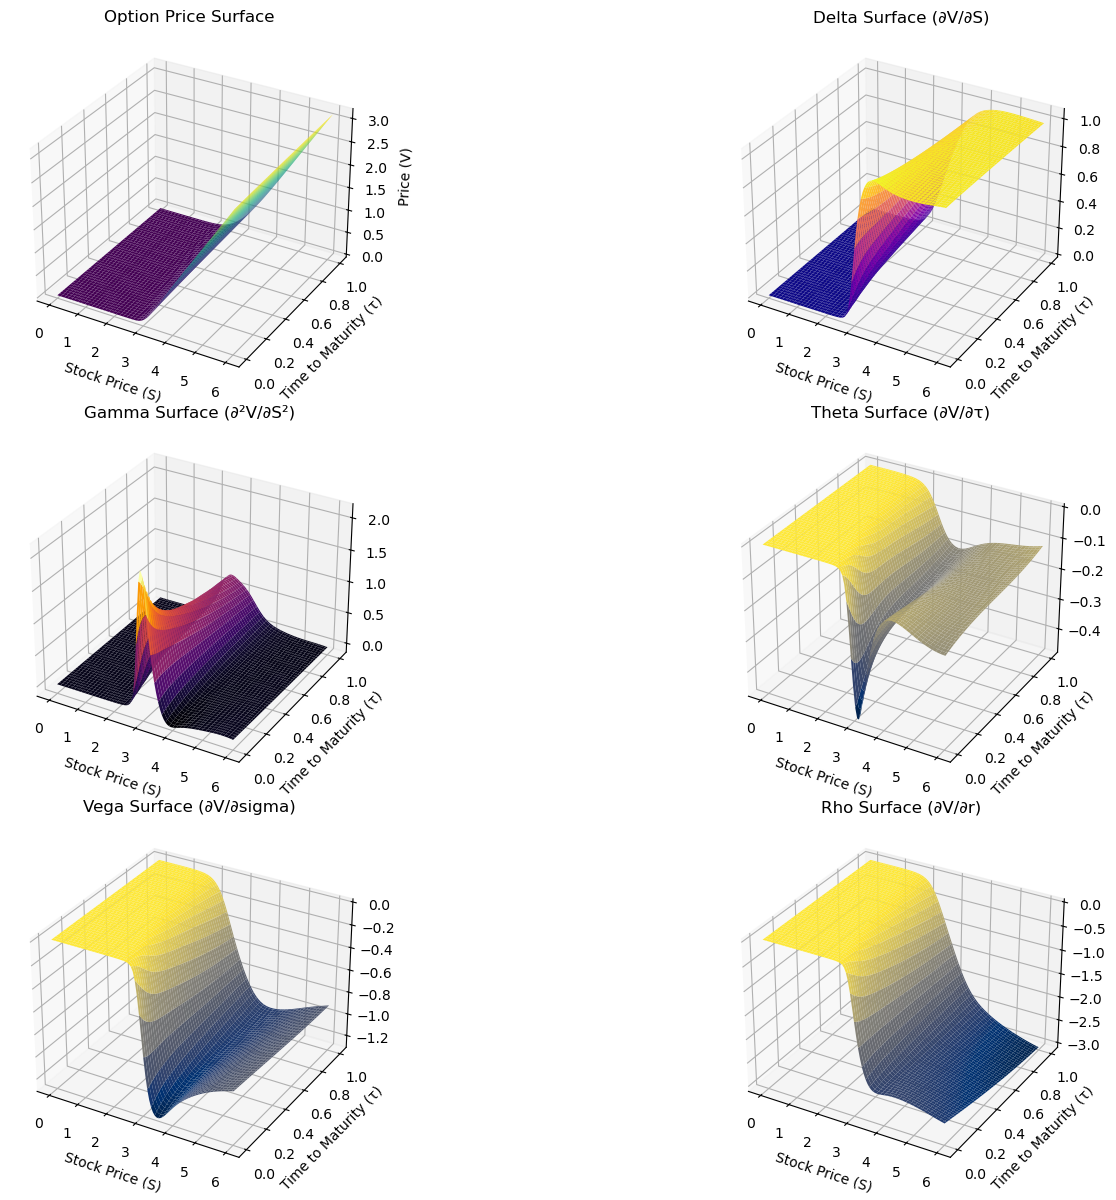


Sample Greeks at S=3, τ=0.5:
Price: 0.2094
Delta: 0.5891
Gamma: 0.8937
Theta: -0.2312
Vega: -0.7636
Rho: -1.3603


In [7]:
# ================== Greeks Surface Computation ==================
Delta_grid = np.zeros_like(S_grid)
Gamma_grid = np.zeros_like(S_grid)
Theta_grid = np.zeros_like(S_grid)
Vega_grid = np.zeros_like(S_grid)
Rho_grid = np.zeros_like(S_grid)

for i in range(N_points):
    for j in range(N_points):
        greeks = compute_greeks(pinn, 
                              torch.tensor([[S_grid[i,j]]], dtype=torch.float32),
                              torch.tensor([[Tau_grid[i,j]]], dtype=torch.float32),
                              sigma_tensor, r_tensor)
        Delta_grid[i,j] = greeks['Delta']
        Gamma_grid[i,j] = greeks['Gamma']
        Theta_grid[i,j] = greeks['Theta']
        Vega_grid[i,j] = greeks['Vega']
        Rho_grid[i,j] = greeks['Rho']

# ================== Visualization ==================
fig = plt.figure(figsize=(18, 12))

# Price Surface
ax1 = fig.add_subplot(321, projection='3d')
ax1.plot_surface(S_grid, Tau_grid, V_pred, cmap='viridis')
ax1.set_title('Option Price Surface')
ax1.set_xlabel('Stock Price (S)')
ax1.set_ylabel('Time to Maturity (τ)')
ax1.set_zlabel('Price (V)')

# Delta Surface
ax2 = fig.add_subplot(322, projection='3d')
ax2.plot_surface(S_grid, Tau_grid, Delta_grid, cmap='plasma')
ax2.set_title('Delta Surface (∂V/∂S)')
ax2.set_xlabel('Stock Price (S)')
ax2.set_ylabel('Time to Maturity (τ)')

# Gamma Surface
ax3 = fig.add_subplot(323, projection='3d')
ax3.plot_surface(S_grid, Tau_grid, Gamma_grid, cmap='inferno')
ax3.set_title('Gamma Surface (∂²V/∂S²)')
ax3.set_xlabel('Stock Price (S)')
ax3.set_ylabel('Time to Maturity (τ)')

# Theta Surface
ax4 = fig.add_subplot(324, projection='3d')
ax4.plot_surface(S_grid, Tau_grid, Theta_grid, cmap='cividis')
ax4.set_title('Theta Surface (∂V/∂τ)')
ax4.set_xlabel('Stock Price (S)')
ax4.set_ylabel('Time to Maturity (τ)')

# Vega Surface
ax4 = fig.add_subplot(325, projection='3d')
ax4.plot_surface(S_grid, Tau_grid, Vega_grid, cmap='cividis')
ax4.set_title('Vega Surface (∂V/∂sigma)')
ax4.set_xlabel('Stock Price (S)')
ax4.set_ylabel('Time to Maturity (τ)')

# Rho Surface
ax4 = fig.add_subplot(326, projection='3d')
ax4.plot_surface(S_grid, Tau_grid, Rho_grid, cmap='cividis')
ax4.set_title('Rho Surface (∂V/∂r)')
ax4.set_xlabel('Stock Price (S)')
ax4.set_ylabel('Time to Maturity (τ)')

plt.tight_layout()
plt.show()

# Print sample Greeks at S=55, τ=0.5
print("\nSample Greeks at S=3, τ=0.5:")
sample_greeks = compute_greeks(pinn, 
                              torch.tensor([[3.0]], dtype=torch.float32),
                              torch.tensor([[0.5]], dtype=torch.float32),
                              sigma_tensor, r_tensor)
for key, val in sample_greeks.items():
    print(f"{key}: {val:.4f}")

In [8]:
# Create the 3D surface plot
fig = go.Figure(data=[go.Surface(z=Delta_grid, x=Tau_grid[0, :], y=S_grid[:, 0])])

# Customize the layout
fig.update_layout(
    title='3D Surface Plot from Array',
    scene=dict(
        xaxis_title='X Axis',
        yaxis_title='Y Axis',
        zaxis_title='Z Axis',
        camera=dict(
            eye=dict(x=1.5, y=1.5, z=0.8)  # Adjust camera view
        )
    ),
    autosize=False,
    width=800,
    height=700,
    margin=dict(l=65, r=50, b=65, t=90)
)

# Show the plot
fig.show()

Epoch    0 | Loss: 2732.360107 | EMA: 2732.360107
Epoch  500 | Loss: 1381.604614 | EMA: 1396.950715
Epoch 1000 | Loss: 741.467896 | EMA: 750.226033
Epoch 1500 | Loss: 370.509705 | EMA: 375.502832
Epoch 2000 | Loss: 165.288345 | EMA: 167.966397
Epoch 2500 | Loss: 63.078972 | EMA: 64.278595
Epoch 3000 | Loss: 19.495146 | EMA: 20.080632
Epoch 3500 | Loss: 5.101801 | EMA: 5.144523
Epoch 4000 | Loss: 1.354166 | EMA: 1.426527
Epoch 4500 | Loss: 0.569940 | EMA: 0.630269
Epoch 5000 | Loss: 0.360129 | EMA: 0.397589
Epoch 5500 | Loss: 0.294050 | EMA: 0.303217
Epoch 6000 | Loss: 0.186569 | EMA: 0.188505

Early stopping at epoch 6479

=== Sample Greeks ===
Price: 0.7544
Delta: -0.1767
Gamma: 0.0414
Theta: -1.3149
Vega: 0.8965
Rho: 4.4733


c:\Users\svbor\anaconda3\Lib\site-packages\torch\functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\TensorShape.cpp:3638.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


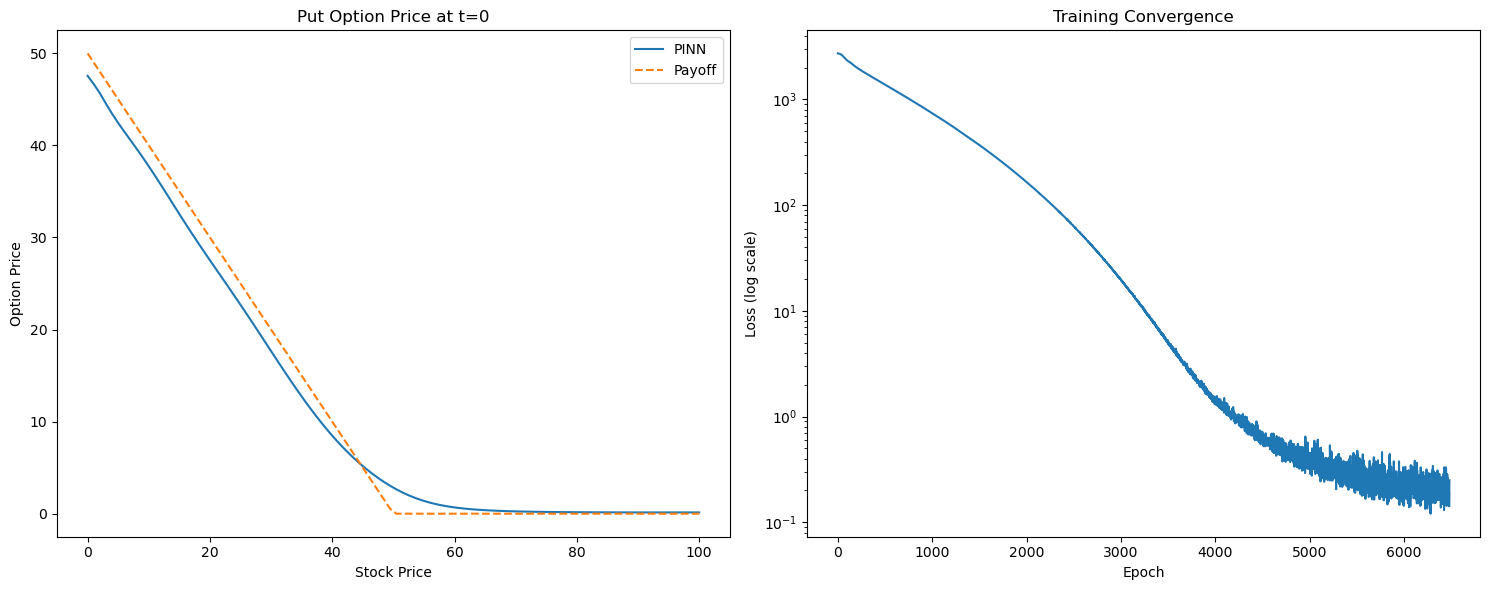

In [2]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go
from scipy.stats import norm

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# ================== Financial Parameters ==================
K = 50.0               # Strike price
T = 1.0                # Time to maturity
r = 0.05               # Risk-free rate
sigma = 0.2            # Volatility
S_max = 2 * K          # Maximum stock price boundary
option_type = 'put'     # 'call' or 'put'
is_american = False     # American exercise style

# ================== PINN Architecture ==================
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(4, 20),    # Input: (S, tau, sigma, r)
            nn.Tanh(),
            nn.Linear(20, 20),
            nn.Tanh(),
            nn.Linear(20, 20),
            nn.Tanh(),
            nn.Linear(20, 1),   # Output: V(S, tau, sigma, r)
            nn.Softplus()        # Ensures V >= 0
        )
        
    def forward(self, S, tau, sigma, r):
        sigma_tensor = torch.ones_like(S) * sigma
        r_tensor = torch.ones_like(S) * r
        inputs = torch.cat([S, tau, sigma_tensor, r_tensor], dim=1)
        return self.net(inputs)

# ================== Black-Scholes PDE ==================
def bs_pde(pinn, S, tau, sigma, r):
    S = S.clone().requires_grad_(True)
    tau = tau.clone().requires_grad_(True)
    
    V = pinn(S, tau, sigma, r)
    V_tau = torch.autograd.grad(V.sum(), tau, create_graph=True)[0]
    V_S = torch.autograd.grad(V.sum(), S, create_graph=True)[0]
    V_SS = torch.autograd.grad(V_S.sum(), S, create_graph=True)[0]
    
    # Black-Scholes PDE (same for calls/puts)
    residual = V_tau - (0.5 * sigma**2 * S**2 * V_SS + r * S * V_S - r * V)
    return residual

# ================== Greeks Computation ==================
def compute_greeks(pinn, S, tau, sigma=sigma, r=r, eps=1e-4):
    S = S.clone().requires_grad_(True)
    tau = tau.clone().requires_grad_(True)
    
    V = pinn(S, tau, sigma, r)
    
    # First-order Greeks
    Delta = torch.autograd.grad(V.sum(), S, create_graph=True)[0]
    Theta = -torch.autograd.grad(V.sum(), tau, create_graph=True)[0]
    
    # Second-order Greeks
    Gamma = torch.autograd.grad(Delta.sum(), S, create_graph=True)[0]
    
    # Numerical Greeks
    V_sigma_plus = pinn(S, tau, sigma + eps, r)
    Vega = (V_sigma_plus - V) / eps
    
    V_r_plus = pinn(S, tau, sigma, r + eps)
    Rho = (V_r_plus - V) / eps
    
    return {
        'Price': V.item(),
        'Delta': Delta.item(),
        'Gamma': Gamma.item(),
        'Theta': Theta.item(),
        'Vega': Vega.item(),
        'Rho': Rho.item()
    }

# ================== Payoff and Boundary Conditions ==================
def get_payoff(S, K, option_type):
    if option_type == 'call':
        return torch.relu(S - K)
    else:  # put
        return torch.relu(K - S)

def get_boundary_conditions(option_type, S_max, K, r, T, N_tau):
    boundary_tau = torch.linspace(0, T, N_tau).view(-1, 1)
    
    if option_type == 'call':
        # Call boundary conditions
        boundary_S0 = torch.zeros(N_tau, 1)
        boundary_Smax = S_max * torch.ones(N_tau, 1)
        boundary_V0 = torch.zeros(N_tau, 1)  # Call value at S=0
        boundary_Vmax = boundary_Smax - K * torch.exp(-r * boundary_tau)  # Call value at S_max
    else:
        # Put boundary conditions
        boundary_S0 = torch.zeros(N_tau, 1)
        boundary_Smax = S_max * torch.ones(N_tau, 1)
        boundary_V0 = K * torch.exp(-r * boundary_tau)  # Put value at S=0
        boundary_Vmax = torch.zeros(N_tau, 1)           # Put value at S_max
    
    return boundary_S0, boundary_Smax, boundary_tau, boundary_V0, boundary_Vmax

# ================== Early Exercise Penalty ==================
def early_exercise_penalty(pinn, S, tau, K, sigma, r, option_type):
    V_pred = pinn(S, tau, sigma, r)
    payoff = get_payoff(S, K, option_type)
    return torch.mean(torch.relu(payoff - V_pred))  # Penalty if V < payoff

# ================== Training Setup ==================
pinn = PINN()
optimizer = torch.optim.Adam(pinn.parameters(), lr=0.001)

# Grid parameters
N_S = 100
N_tau = 100

# Terminal condition
terminal_S = torch.linspace(0, S_max, N_S).view(-1, 1)
terminal_tau = torch.zeros(N_S, 1)
terminal_V = get_payoff(terminal_S, K, option_type)

# Boundary conditions
boundary_S0, boundary_Smax, boundary_tau, boundary_V0, boundary_Vmax = \
    get_boundary_conditions(option_type, S_max, K, r, T, N_tau)

# ================== Training Loop ==================
epochs = 10000
train_losses = []
ema_loss = None
ema_alpha = 0.1
best_loss = float('inf')
patience = 200
wait = 0

for epoch in range(epochs):
    optimizer.zero_grad()
    
    # Loss components
    pred_terminal = pinn(terminal_S, terminal_tau, sigma, r)
    loss_terminal = torch.mean((pred_terminal - terminal_V)**2)
    
    pred_boundary0 = pinn(boundary_S0, boundary_tau, sigma, r)
    pred_boundary_max = pinn(boundary_Smax, boundary_tau, sigma, r)
    loss_boundary = (torch.mean((pred_boundary0 - boundary_V0)**2) + 
                    torch.mean((pred_boundary_max - boundary_Vmax)**2))
    
    S_colloc = torch.rand(N_S, 1, requires_grad=True) * S_max
    tau_colloc = torch.rand(N_tau, 1, requires_grad=True) * T
    residual = bs_pde(pinn, S_colloc, tau_colloc, sigma, r)
    loss_pde = torch.mean(residual**2)
    
    # American option penalty
    if is_american:
        loss_american = early_exercise_penalty(
            pinn, S_colloc, tau_colloc, K, sigma, r, option_type)
    else:
        loss_american = torch.tensor(0.0)
    
    # Total loss
    loss = loss_terminal + loss_boundary + loss_pde + 0.5 * loss_american
    train_losses.append(loss.item())
    loss.backward()
    optimizer.step()
    
    # EMA tracking
    ema_loss = ema_alpha * loss.item() + (1 - ema_alpha) * ema_loss if ema_loss else loss.item()
    
    # Early stopping
    if epoch > 100:
        if loss.item() < best_loss - 1e-5:
            best_loss = loss.item()
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                print(f"\nEarly stopping at epoch {epoch}")
                break
    
    if epoch % 500 == 0 or epoch == epochs - 1:
        print(f"Epoch {epoch:4d} | Loss: {loss.item():.6f} | EMA: {ema_loss:.6f}")

# ================== Post-Training Analysis ==================
# Generate test grid
S_test = torch.linspace(0, S_max, N_S).view(-1, 1)
tau_test = torch.linspace(0, T, N_tau).view(-1, 1)
S_grid, Tau_grid = torch.meshgrid(S_test.squeeze(), tau_test.squeeze())

# Predict option prices
with torch.no_grad():
    V_pred = pinn(
        S_grid.reshape(-1, 1),
        Tau_grid.reshape(-1, 1),
        torch.ones_like(S_grid.reshape(-1, 1)) * sigma,
        torch.ones_like(S_grid.reshape(-1, 1)) * r
    ).reshape(N_S, N_tau).numpy()

# Compute Greeks at sample point
print("\n=== Sample Greeks ===")
sample_greeks = compute_greeks(
    pinn, 
    torch.tensor([[55.0]], dtype=torch.float32),
    torch.tensor([[0.5]], dtype=torch.float32),
    sigma, r
)
for greek, value in sample_greeks.items():
    print(f"{greek}: {value:.4f}")

# ================== Visualization ==================
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(S_test.numpy(), V_pred[:, -1], label='PINN')
plt.plot(S_test.numpy(), get_payoff(S_test, K, option_type).numpy(), '--', label='Payoff')
plt.xlabel('Stock Price')
plt.ylabel('Option Price')
plt.title(f'{option_type.capitalize()} Option Price at t=0')
plt.legend()

plt.subplot(1, 2, 2)
plt.semilogy(train_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss (log scale)')
plt.title('Training Convergence')
plt.tight_layout()
plt.show()